In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

sns.set(style='whitegrid')

# Importing the Datasets

In [2]:
# Load the Indirect dataset : 2 Variables
dfi = pd.read_csv('indirect1.csv')
print("First few rows of the dataset:")
dfi.head()

First few rows of the dataset:


,Number of data points,Reference,Rock,Entry fluid,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
1,Amann-Hildenbrand,2013,Shale,He,9,0.74,4.3,3.6
2,Amann-Hildenbrand,2013,Shale,He,14,0.87,4.3,4.1
3,Amann-Hildenbrand,2013,Shale,Hg,12,0.27,4.5,4.2
4,Amann-Hildenbrand,2013,Shale,Hg,8,1.52,9.1,3.8
5,Amann-Hildenbrand,2013,Shale,Hg,9,4.05,8.7,4.7


In [3]:
# Load the Indirect dataset : 5 Variables
dfi1 = pd.read_csv('indirect2.csv')
print("First few rows of the dataset:")
dfi1.head()

First few rows of the dataset:


,Number of data points,Reference,Rock,Entry fluid,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore radius [nm],Clay content [%],Breakthrough pressure [MPa]
1,Amann-Hildenbrand,2013,Shale,He,9,0.74,4.3,7.7,7.0,34.0,3.6
2,Amann-Hildenbrand,2013,Shale,Hg,12,0.27,4.5,23.3,4.0,38.0,4.2
3,Amann-Hildenbrand,2013,Shale,Hg,9,4.05,8.7,25.9,5.0,39.0,4.7
4,Amann-Hildenbrand,2013,Shale,Hg,20,24.26,8.7,22.5,8.0,41.0,2.7
5,Amann-Hildenbrand,2013,Shale,Hg,26,14.52,5.0,12.9,7.0,40.0,3.2


In [4]:
# Load the Direct dataset : 2 Variables
df = pd.read_csv('final1.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,6.9,11.6,4.1
1,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.0,13.0,17.5
2,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.5,13.0,14.0
3,Boulin et al. 2013,Ketzin Claystone,7.0,31.8,15.0,10.4
4,Boulin et al. 2013,Ketzin Claystone,25.0,15.6,15.0,13.0


In [5]:
# Load the Direct dataset : 5 Variables
df1 = pd.read_csv('final2.csv')
print("First few rows of the dataset:")

df1 = df1.rename(columns={'Pore diameter [nm]': 'Pore radius [nm]'})
df1.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore radius [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


In [6]:
dfi1.shape

(36, 11)

In [7]:
train_cols_2 = ['Permeability [nD]', 'Porosity [%]']
train_cols_5 = ['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore radius [nm]',
              'Clay content [%]']
target = 'Breakthrough pressure [MPa]'

In [8]:
indirect_data_2 = dfi
indirect_data_5 = dfi1
direct_data_2 = df
direct_data_5 = df1

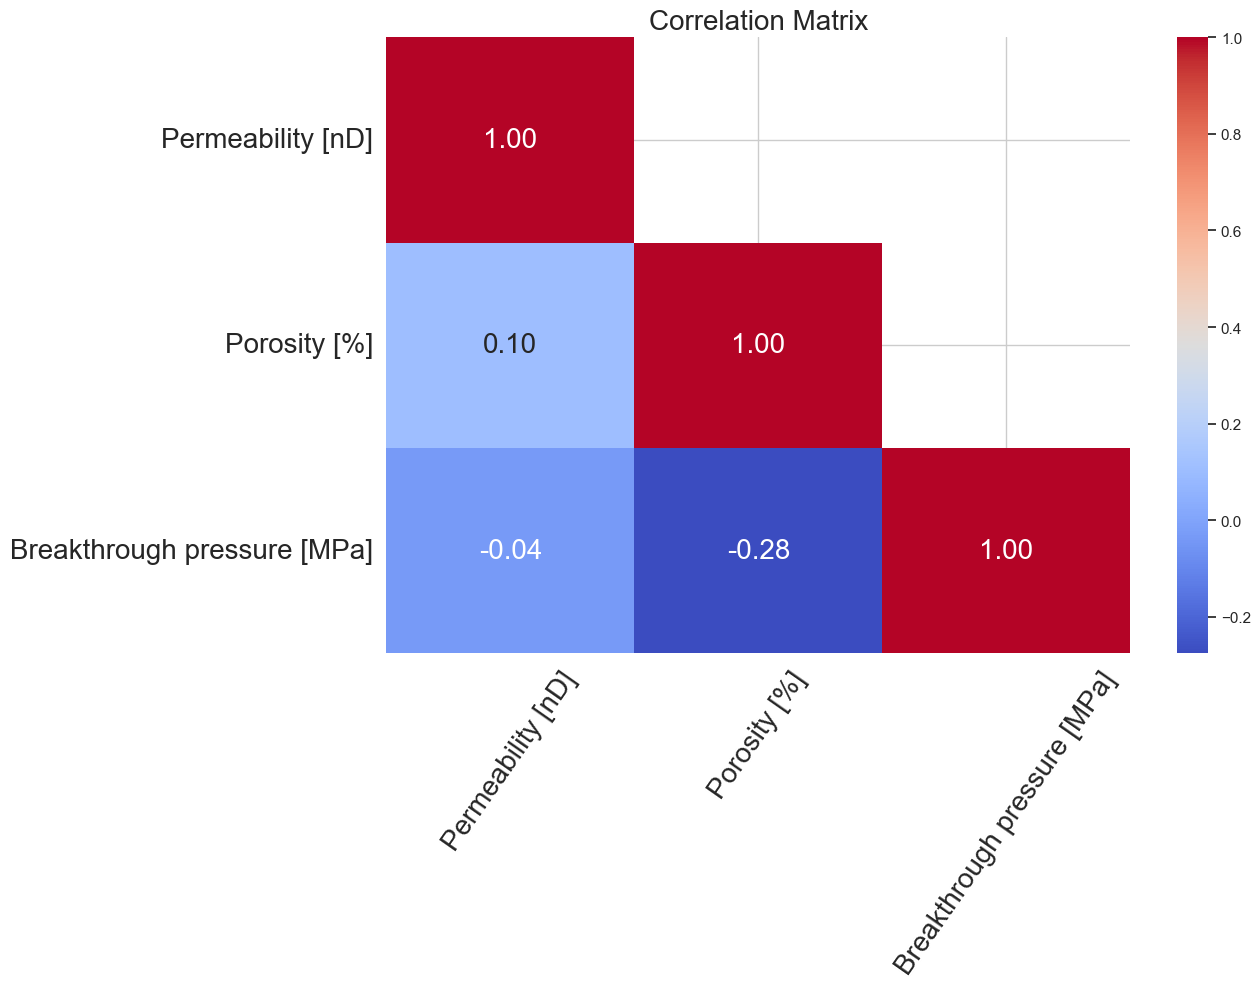

In [9]:
cols = ['Permeability [nD]', 'Porosity [%]',  'Breakthrough pressure [MPa]']
correlation_matrix = dfi[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontsize=20, fontname='Arial')
plt.show()

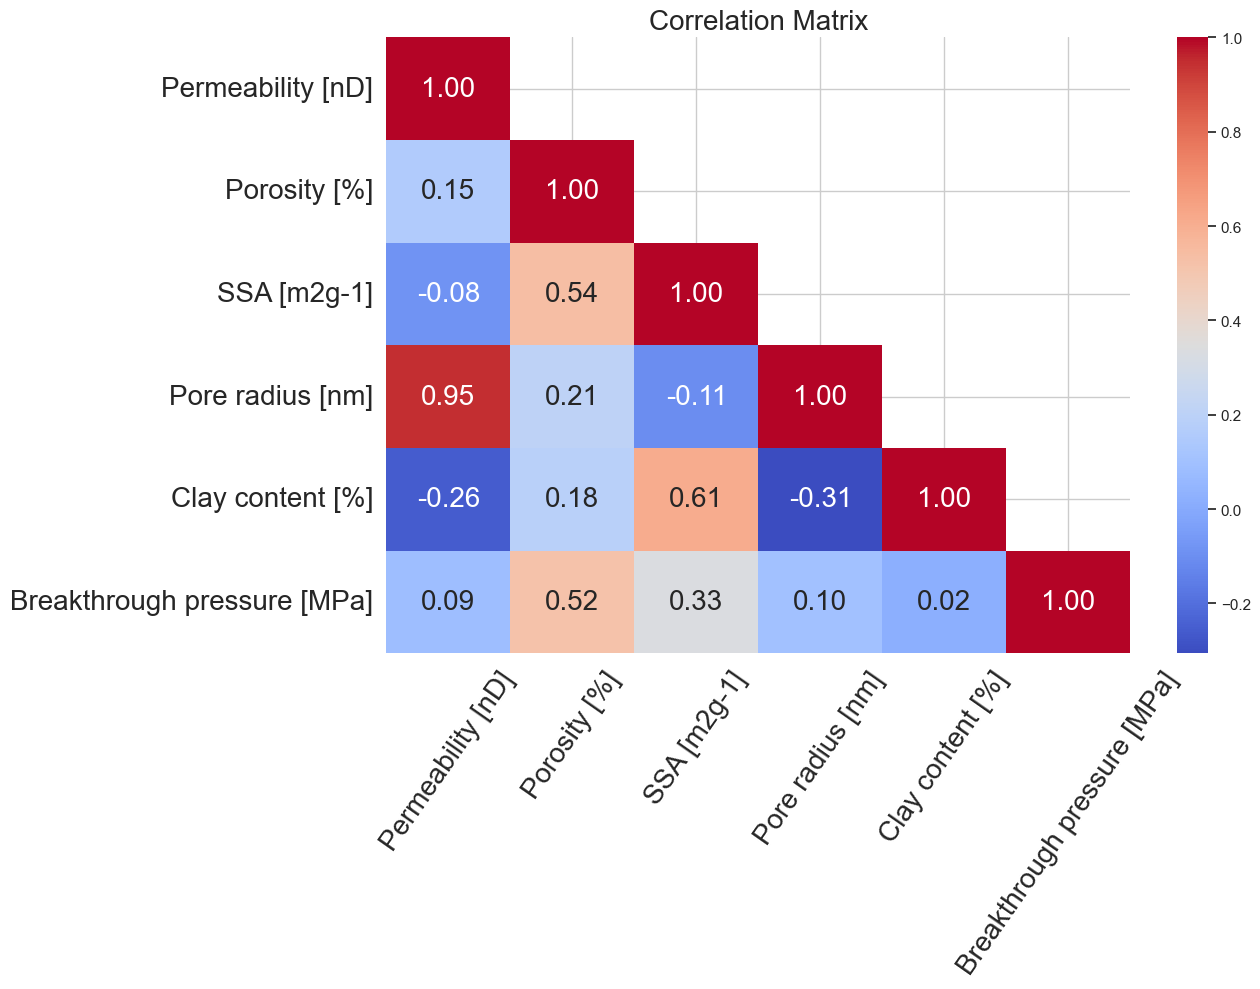

In [10]:
cols = ['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore radius [nm]',
              'Clay content [%]',  'Breakthrough pressure [MPa]']
correlation_matrix = dfi1[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontsize=20, fontname='Arial')
plt.show()

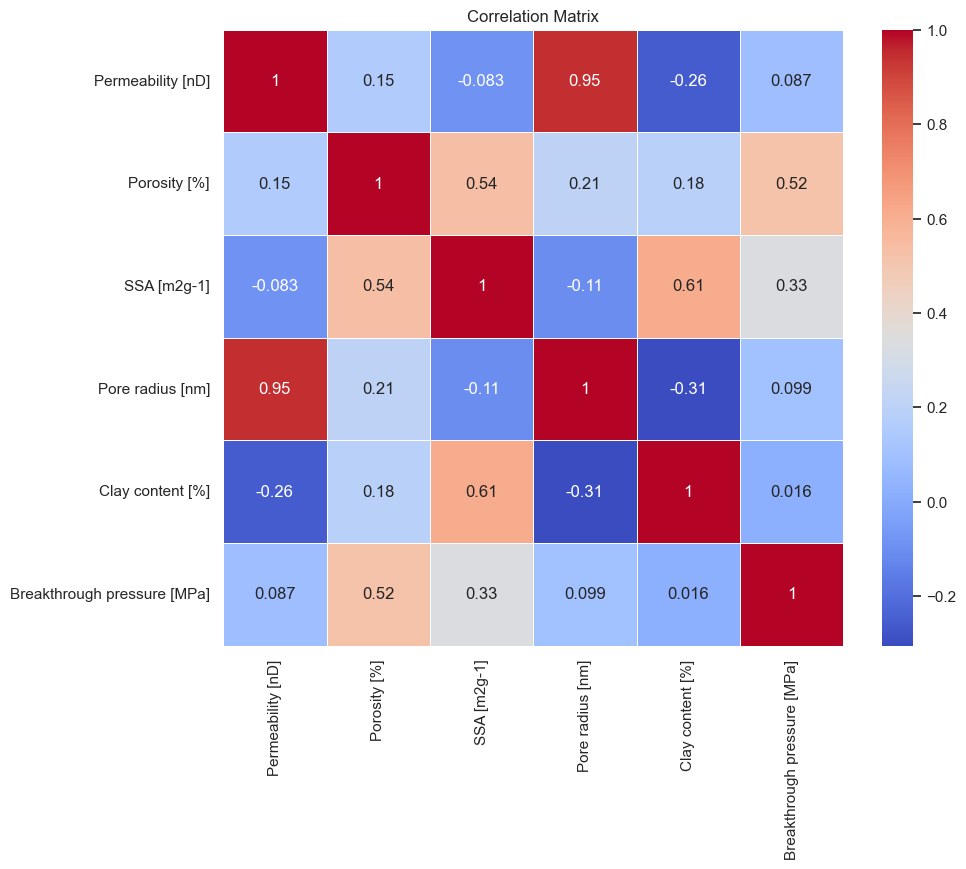

In [11]:
corr_matrix = dfi1[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
X_indirect = indirect_data_2.drop('Breakthrough pressure [MPa]', axis=1)
y_indirect = indirect_data_2['Breakthrough pressure [MPa]']
# Perform bootstrapped resampling to oversample indirect data
bootstrap_samples1 = resample(indirect_data_2, 
                             replace=True, 
                             n_samples=500,
                             random_state=42)

X_train_bootstrap = bootstrap_samples1.drop('Breakthrough pressure [MPa]', axis=1)
y_train_bootstrap = bootstrap_samples1['Breakthrough pressure [MPa]']

In [23]:
cols = ['Permeability [nD]', 'Porosity [%]',  'Breakthrough pressure [MPa]']
cols1 = ['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore radius [nm]',
              'Clay content [%]',  'Breakthrough pressure [MPa]']

In [24]:
X_indirect = indirect_data_5.drop('Breakthrough pressure [MPa]', axis=1)
y_indirect = indirect_data_5['Breakthrough pressure [MPa]']

# Perform bootstrapped resampling to oversample indirect data
bootstrap_samples2 = resample(indirect_data_5, 
                             replace=True, 
                             n_samples=200,
                             random_state=42)

X_train_bootstrap = bootstrap_samples2.drop('Breakthrough pressure [MPa]', axis=1)
y_train_bootstrap = bootstrap_samples2['Breakthrough pressure [MPa]']

/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_50482/1777858162.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


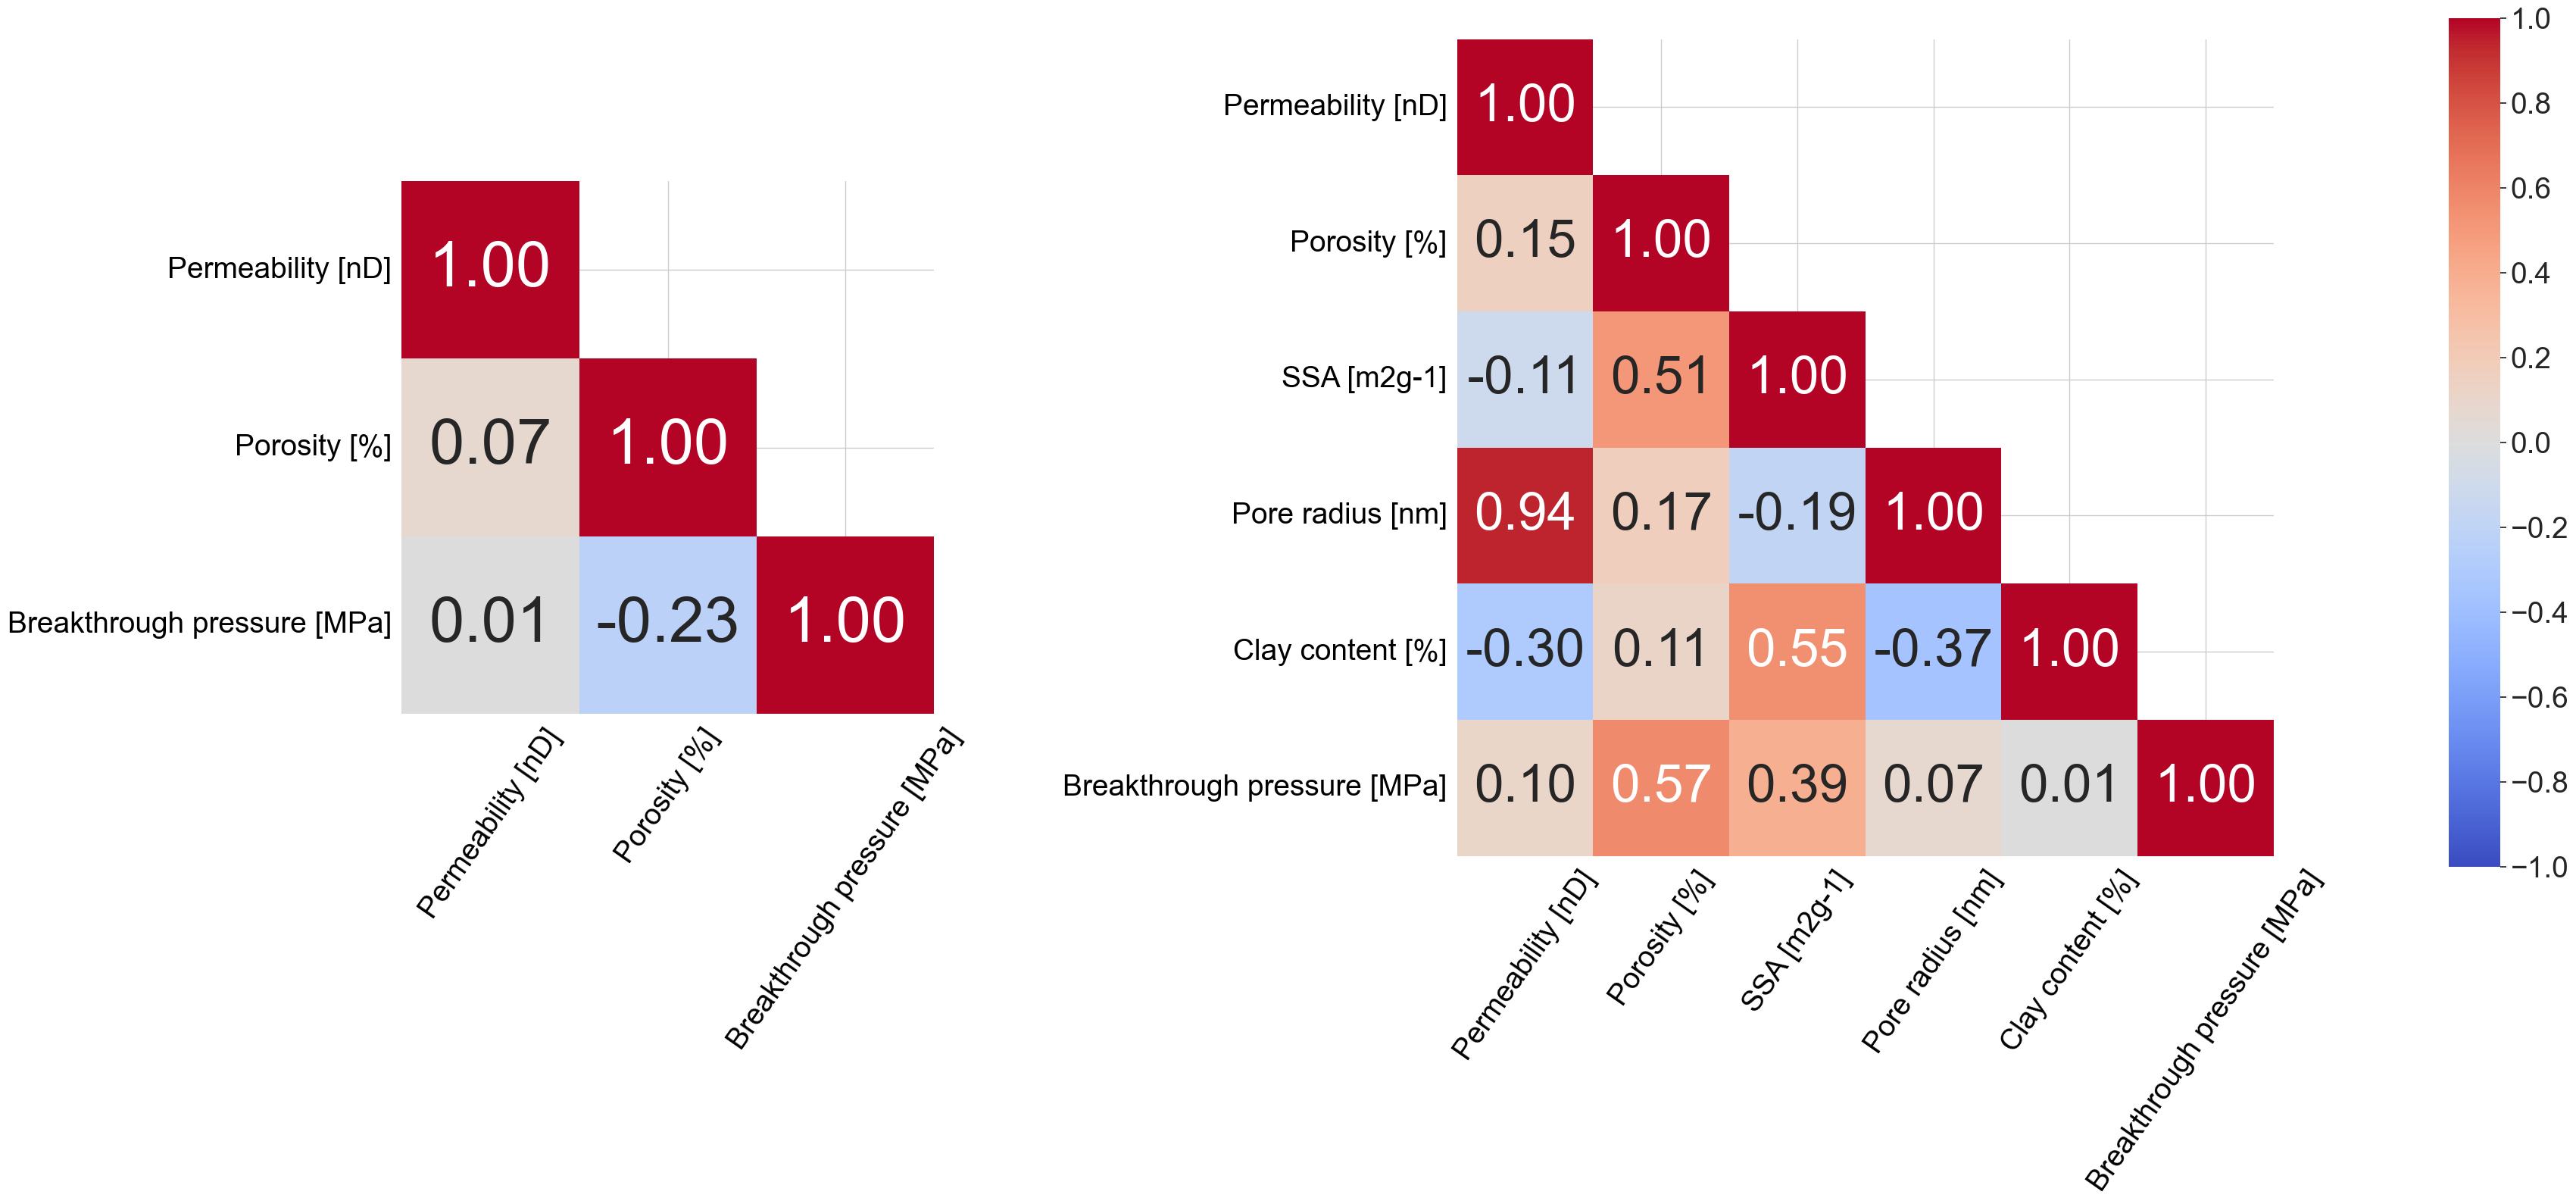

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming df and df1 are your original dataframes
correlation_matrix_df = bootstrap_samples1[cols].corr()
correlation_matrix_df1 = bootstrap_samples2[cols1].corr()

# Generate masks for upper triangles of both correlation matrices
mask_df = np.triu(np.ones_like(correlation_matrix_df, dtype=bool), k=1)
mask_df1 = np.triu(np.ones_like(correlation_matrix_df1, dtype=bool), k=1)

# Create subplots with adjusted width ratios based on column count
fig, axes = plt.subplots(1, 2, figsize=(34, 14), gridspec_kw={'width_ratios': [len(correlation_matrix_df.columns), len(correlation_matrix_df1.columns)], 'wspace': 0.5})

# Create a shared color bar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

# First heatmap with the mask applied, set vmin and vmax for color bar range
sns.heatmap(correlation_matrix_df, annot=True, mask=mask_df, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 60}, ax=axes[0], cbar=False, square=True, vmin=-1, vmax=1)
axes[0].set_title('', fontsize=28, fontname='Arial')
axes[0].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[0].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')

# Second heatmap with the mask applied, set vmin and vmax for color bar range
sns.heatmap(correlation_matrix_df1, annot=True, mask=mask_df1, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 50}, ax=axes[1], cbar_ax=cbar_ax, square=True, vmin=-1, vmax=1,
            cbar_kws={'shrink': 1.0, 'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]})
axes[1].set_title('', fontsize=28, fontname='Arial')
axes[1].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[1].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')

# Set color bar tick size
cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

# Adjust layout and spacing between plots
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.5)

plt.show()


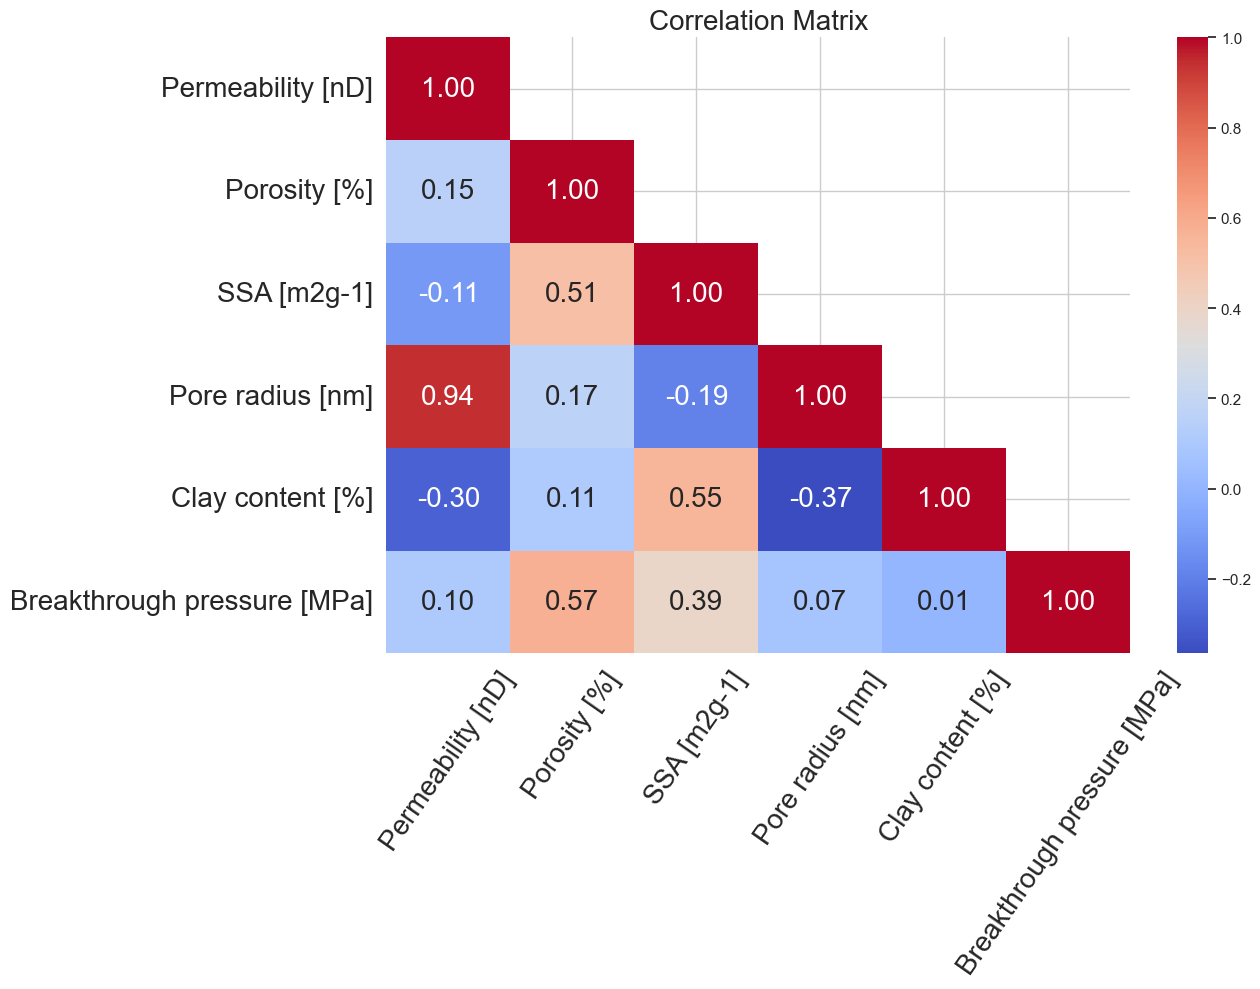

In [15]:

correlation_matrix = bootstrap_samples2[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontsize=20, fontname='Arial')
plt.show()

/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_50482/1353885238.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


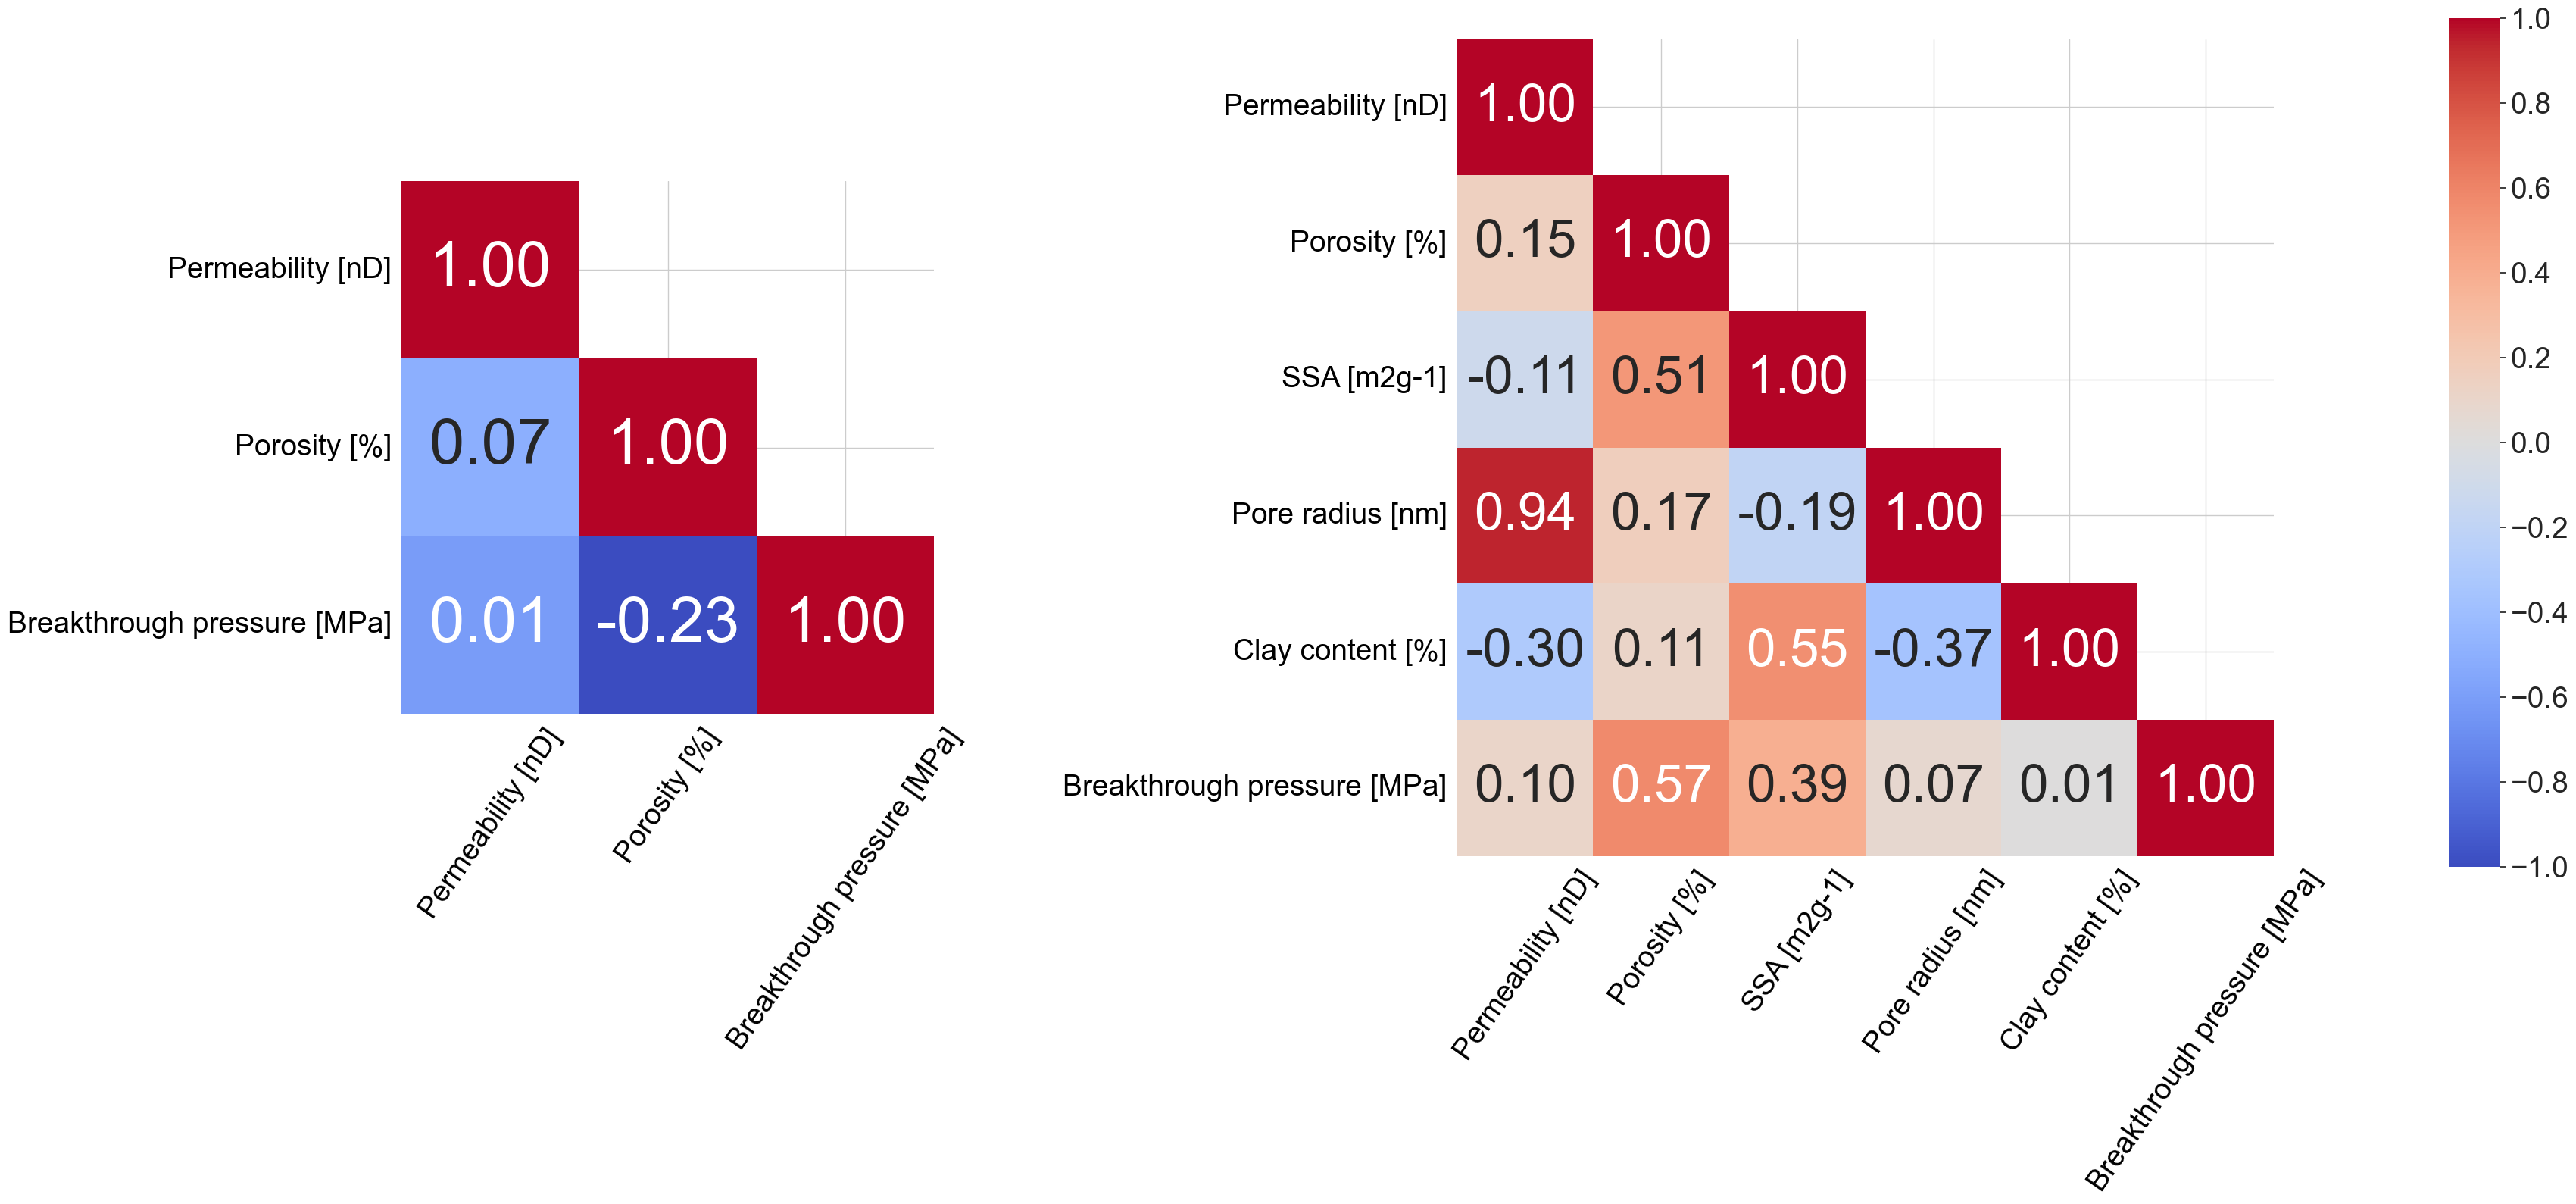

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming df and df1 are your original dataframes
correlation_matrix_df = bootstrap_samples1[['Permeability [nD]', 'Porosity [%]',  'Breakthrough pressure [MPa]']].corr()
correlation_matrix_df1 = bootstrap_samples2[['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore radius [nm]',
              'Clay content [%]',  'Breakthrough pressure [MPa]']].corr()

# Generate masks for upper triangles of both correlation matrices
mask_df = np.triu(np.ones_like(correlation_matrix_df, dtype=bool), k=1)
mask_df1 = np.triu(np.ones_like(correlation_matrix_df1, dtype=bool), k=1)

# Create subplots with adjusted width ratios based on column count
fig, axes = plt.subplots(1, 2, figsize=(34, 14), gridspec_kw={'width_ratios': [len(correlation_matrix_df.columns), len(correlation_matrix_df1.columns)], 'wspace': 0.5})

# Create a shared color bar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

# First heatmap with the mask applied
sns.heatmap(correlation_matrix_df, annot=True, mask=mask_df, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 60}, ax=axes[0], cbar=False, square=True)
axes[0].set_title('', fontsize=28, fontname='Arial')
axes[0].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[0].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')


# Second heatmap with the mask applied and color bar
sns.heatmap(correlation_matrix_df1, annot=True, mask=mask_df1, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 50}, ax=axes[1], cbar_ax=cbar_ax, square=True, vmin=-1, vmax=1,
            cbar_kws={'shrink': 1.0, 'ticks': [1, -1, -0.8,-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8 ]})
axes[1].set_title('', fontsize=28, fontname='Arial')
axes[1].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[1].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')

# Set color bar tick size
cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

# Adjust layout and spacing between plots
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.5)

plt.show()


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

correlation_matrix_df = df[['Permeability [nD]', 'Porosity [%]',
       'Breakthrough pressure [MPa]']].corr()
correlation_matrix_df1 = df1[['Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']].corr()

mask_df = np.triu(np.ones_like(correlation_matrix_df, dtype=bool), k=1)
mask_df1 = np.triu(np.ones_like(correlation_matrix_df1, dtype=bool), k=1)

fig, axes = plt.subplots(1, 2, figsize=(34, 14), gridspec_kw={'width_ratios': [len(correlation_matrix_df.columns), len(correlation_matrix_df1.columns)], 'wspace': 0.5})

cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

sns.heatmap(correlation_matrix_df, annot=True, mask=mask_df, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 60}, ax=axes[0], cbar=False, square=True)
axes[0].set_title('', fontsize=28, fontname='Arial')
axes[0].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[0].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')


sns.heatmap(correlation_matrix_df1, annot=True, mask=mask_df1, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 50}, ax=axes[1], cbar_ax=cbar_ax, square=True,
            cbar_kws={'shrink': 1.0, 'ticks': [1, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8 ]})
axes[1].set_title('', fontsize=28, fontname='Arial')
axes[1].tick_params(axis='y', rotation=0, labelsize=28, labelcolor='black')
axes[1].tick_params(axis='x', labelsize=28, labelrotation=55, labelcolor='black')

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.5)

plt.show()


KeyError: "['Pore diameter [nm]'] not in index"

# Working with 2 Variables

## Simple XGBoost on Indirect

In [98]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [99]:
# Split the data into training and testing sets
X_indirect = indirect_data_2.drop('Breakthrough pressure [MPa]', axis=1)
y_indirect = indirect_data_2['Breakthrough pressure [MPa]']

X_train, X_test, y_train, y_test = train_test_split(
    X_indirect, y_indirect, test_size=0.2, random_state=42
)


In [100]:
# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression
    random_state=42                # For reproducibility
)


In [101]:
X_train

,Number of data points,Reference,Rock,Entry fluid,P’[MPa],Permeability [nD],Porosity [%]
41,Hildenbrand et al.,2004,Mudrock,N2,20,20.26,29.90
68,Pusch & Forsberg,1983,Bentonite Clay,N2,13,8.50,0.99
16,Harrington & Horseman,1999,Boom Clay,He,4,261.40,3.91
69,Schlömer & Krooss,1997,Claystone,Hg,12,6.90,2.80
89,Tonnet et al.,2011,Rousse caprock,N2,12,0.10,3.14
...,...,...,...,...,...,...,...
61,Marschall et al.,2005,Opalinus Clay,N2,4,2026.34,16.00
72,Schlömer & Krooss,1997,Claystone,Hg,12,36.30,2.80
15,Ito et al.,2011,Mudstone,N2,8,270.00,28.19
93,Zhang & Yu,2016,Mudstone,He,30,0.07,3.14


In [102]:
X_train[train_cols_2]

,Permeability [nD],Porosity [%]
41,20.26,29.90
68,8.50,0.99
16,261.40,3.91
69,6.90,2.80
89,0.10,3.14
...,...,...
61,2026.34,16.00
72,36.30,2.80
15,270.00,28.19
93,0.07,3.14


In [103]:
# Train the model using the bootstrapped training set
model = RandomForestRegressor(random_state=2)
model.fit(X_train[train_cols_2], y_train)

RandomForestRegressor(random_state=2)

In [104]:
# Make predictions on the test data
y_pred = model.predict(X_test[train_cols_2])


In [105]:
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r_squared)


Mean Squared Error (MSE): 1817.5967052676442
Mean Absolute Error (MAE): 22.93069523809524
R-squared: 0.02912666804911901


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_77052/76492721.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


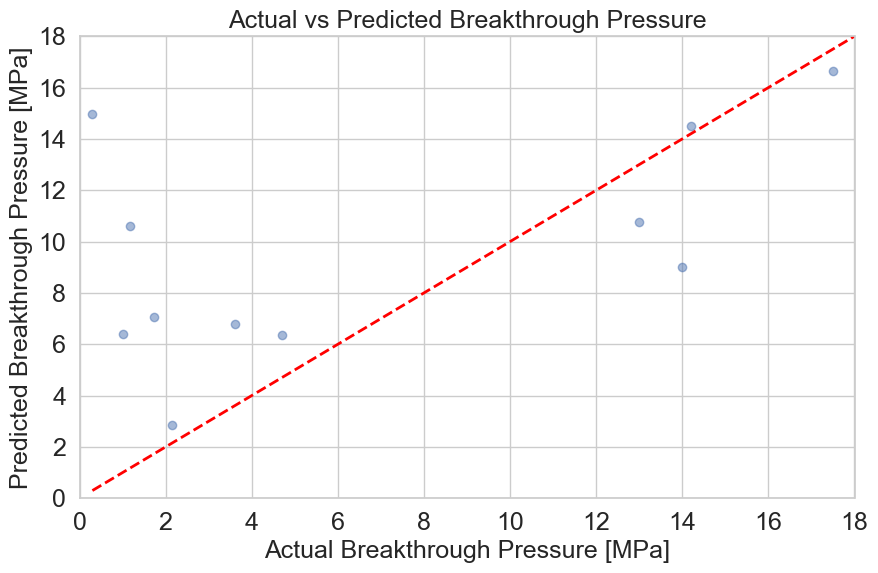

In [106]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')

plt.xlim([0, 12])
plt.ylim([0, 12])

plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=18)
plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=18)
plt.title('Actual vs Predicted Breakthrough Pressure', fontsize=18)

plt.xticks(np.arange(0, 20, 2), fontsize=18)
plt.yticks(np.arange(0, 20, 2), fontsize=18)
plt.show()

## Resampling the dataset

In [122]:
X_indirect = indirect_data_2.drop('Breakthrough pressure [MPa]', axis=1)
y_indirect = indirect_data_2['Breakthrough pressure [MPa]']

In [124]:
# Perform bootstrapped resampling to oversample indirect data
bootstrap_samples1 = resample(indirect_data_2, 
                             replace=True, 
                             n_samples=600,
                             random_state=42)

X_train_bootstrap = bootstrap_samples1.drop('Breakthrough pressure [MPa]', axis=1)
y_train_bootstrap = bootstrap_samples1['Breakthrough pressure [MPa]']

## Preparing the Testing Data

In [109]:
X_test = direct_data_2.drop('Breakthrough pressure [MPa]', axis=1)
y_test = direct_data_2['Breakthrough pressure [MPa]']

In [110]:
X_train_bootstrap.shape

(600, 7)

## Model Building

In [111]:
from sklearn.ensemble import RandomForestRegressor

for seed in range(42,69):
    # Train the model using the bootstrapped training set
    model = RandomForestRegressor(random_state=seed)
    model.fit(X_train_bootstrap[train_cols_2], y_train_bootstrap)

    # Make predictions on the test set (direct data)
    y_pred = model.predict(X_test[train_cols_2])

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    
    print(f'For seed {seed}: Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')

For seed 42: Mean Squared Error: 225.72758584565506
Mean Absolute Error: 7.702969737911132
R-squared: -8.417488023966511
For seed 43: Mean Squared Error: 232.72026653924024
Mean Absolute Error: 7.892295689792837
R-squared: -8.709226787044804
For seed 44: Mean Squared Error: 236.718516509944
Mean Absolute Error: 7.814867377642643
R-squared: -8.876036134138399
For seed 45: Mean Squared Error: 220.25974259801288
Mean Absolute Error: 7.585861388624444
R-squared: -8.189366378538532
For seed 46: Mean Squared Error: 257.6226072480486
Mean Absolute Error: 8.053180704105431
R-squared: -9.748167129738636
For seed 47: Mean Squared Error: 228.21681582008102
Mean Absolute Error: 7.6177728274525105
R-squared: -8.521340166739545
For seed 48: Mean Squared Error: 225.33109987974453
Mean Absolute Error: 7.691688432434704
R-squared: -8.400946395606624
For seed 49: Mean Squared Error: 216.32603619536587
Mean Absolute Error: 7.563924825184499
R-squared: -8.02524982717445
For seed 50: Mean Squared Error: 23

In [112]:
# Make predictions on the test set (direct data)
y_pred = model.predict(X_test[train_cols_2])

In [113]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 210.943047262407
Mean Absolute Error: 7.510423710145649
R-squared: -7.800668353805273


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_77052/76492721.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


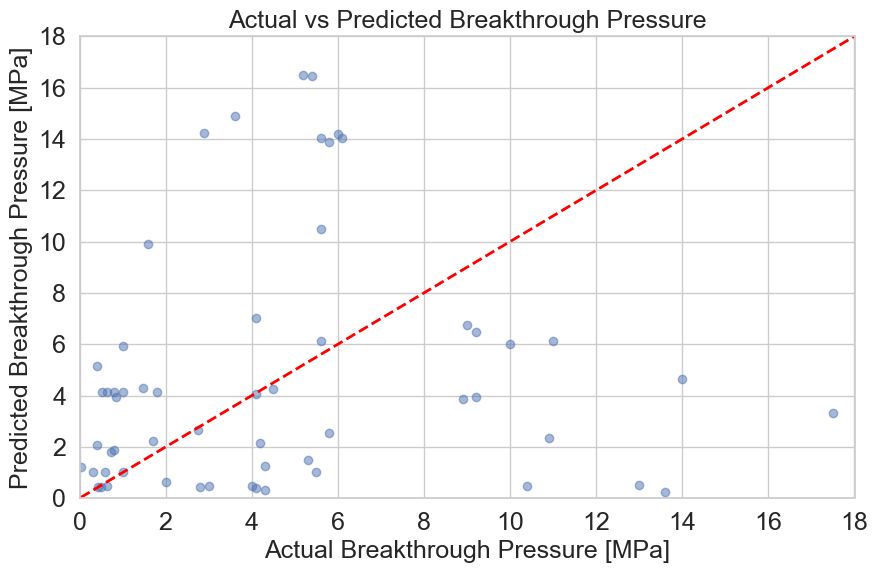

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')

plt.xlim([0, 12])
plt.ylim([0, 12])

plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=18)
plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=18)
plt.title('Actual vs Predicted Breakthrough Pressure', fontsize=18)

plt.xticks(np.arange(0, 20, 2), fontsize=18)
plt.yticks(np.arange(0, 20, 2), fontsize=18)
plt.show()

# Working with 5 Variables

In [115]:
indirect_data_5.dropna().shape

(36, 11)

In [116]:
direct_data_5.dropna().shape

(34, 9)

## Resampling the Data

In [117]:
X_indirect = indirect_data_5.drop('Breakthrough pressure [MPa]', axis=1)
y_indirect = indirect_data_5['Breakthrough pressure [MPa]']

# Perform bootstrapped resampling to oversample indirect data
bootstrap_samples2 = resample(indirect_data_5, 
                             replace=True, 
                             n_samples=200,
                             random_state=42)

X_train_bootstrap = bootstrap_samples2.drop('Breakthrough pressure [MPa]', axis=1)
y_train_bootstrap = bootstrap_samples2['Breakthrough pressure [MPa]']

## Preparing the Testing Data

In [118]:
X_test = direct_data_5.drop('Breakthrough pressure [MPa]', axis=1)
y_test = direct_data_5['Breakthrough pressure [MPa]']

## Model Building

In [119]:
from sklearn.ensemble import RandomForestRegressor

# Train the model using the bootstrapped training set
model = RandomForestRegressor(random_state=42)
model.fit(X_train_bootstrap[train_cols_5], y_train_bootstrap)

RandomForestRegressor(random_state=42)

In [120]:
X_test

,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore radius [nm],Clay content [%]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.00,14.0,60.0
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.10,170.0,3.0
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.60,55.0,40.0
5,Hildenbrand et al. 2004,Boom Clay,20.0,64.8,23.4,20.60,21.0,31.0
6,Hildenbrand et al. 2004,Boom Clay,20.0,17.2,23.4,20.60,21.0,31.0
7,Hildenbrand et al. 2004,Boom Clay,20.0,22.0,24.0,48.20,60.0,56.0
8,Hildenbrand et al. 2004,Boom Clay,20.0,23.3,24.0,48.20,60.0,56.0
9,Hildenbrand et al. 2004,Boom Clay,20.0,19.3,24.0,48.20,60.0,56.0


In [121]:
# Make predictions on the test set (direct data)
y_pred = model.predict(X_test[train_cols_5])

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
X_test[train_cols_5]

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')

plt.xlim([0, 12])
plt.ylim([0, 12])

plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=18)
plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=18)
plt.title('Actual vs Predicted Breakthrough Pressure', fontsize=18)

plt.xticks(np.arange(0, 20, 2), fontsize=18)
plt.yticks(np.arange(0, 20, 2), fontsize=18)
plt.show()